# Free Energy Calculations
In this 

Gibbs Energy:   
$ G_x = V_x - T_x  S_x $

With that we can calculate the free energy difference:
$\Delta G_{ij} = G_j - G_i$ 


In [6]:

#but first some imports:

##System Path
import os, sys
path = os.getcwd()+"/.."
sys.path.append(path)

##basics
import numpy as np
from matplotlib import pyplot as plt

##Ensembler
from ensembler.analysis.freeEnergyCalculation import zwanzigEquation, threeStateZwanzigReweighting, bennetAcceptanceRatio

from ensembler.potentials import OneD as pot
from ensembler.integrator.stochastic import metropolisMonteCarloIntegrator
from ensembler.system.basic_system import system
from ensembler.system.perturbed_system import perturbedSystem
from ensembler.system.eds_system import edsSystem

from ensembler.visualisation.plotSimulations import static_sim_plots

#Benchmarking parameters
simulation_steps_total_per_approach = 10000
rand=0.1

## Setting up a System
We are now going to Setup a system, for the Free Energy Calculations.

Text(0.5, 1.0, 'Two state Potentials')

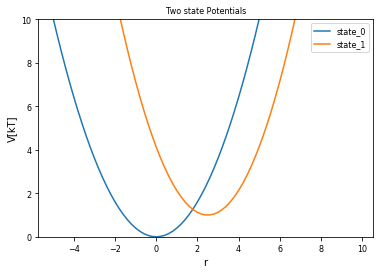

In [7]:
#Build System
#System Parameters:
yoff1 = 0
xoff1 = 0
force_constant = k1 =0.5

entropic_difference = k2 = 1
potential_difference = yoff2 = 1
phase_space_distance = xoff2 = 2.5

#State Potentials
h1, h2 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1), pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)


#Visualize
positions = np.arange(-5,10, 0.2)
ene =  h1.ene(positions)
plt.plot(positions,ene, label="state_0")

ene =  h2.ene(positions)
plt.plot(positions,ene, label="state_1")
    
plt.legend()
plt.ylim([0,10])
plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Two state Potentials")

## Analyctical Solution
The Analytical solution for this system can be calculated as follows: 


Gibbs Energy:   
$ G_x = V_x - T_x  S_x $

For a harmonic Oscillator:
$G_x = V_x - \frac{1}{\beta} log(\sqrt{\frac{2 \pi}{k_X \beta}})$

With that we can calculate the free energy difference:
$\Delta G_{ij} = G_j - G_i$ 


In [8]:
#Analytical Solution
beta = 1 # beta is in kT

G_i = yoff1 -(1/beta) * np.log(np.sqrt((2*np.pi)/(k1*beta)))
G_j = yoff2 -(1/beta) * np.log(np.sqrt((2*np.pi)/(k2*beta)))
dG_expected = G_j-G_i

print("expected dG: ", dG_expected)


expected dG:  1.111571775657105


## Pertubation Methods - BAR/Zwanzig

### Sampling
    



{'bodies': [<matplotlib.collections.PolyCollection object at 0x000002F553540D48>]}



{'bodies': [<matplotlib.collections.PolyCollection object at 0x000002F553705A88>]}


(<Figure size 1152x288 with 3 Axes>, None)

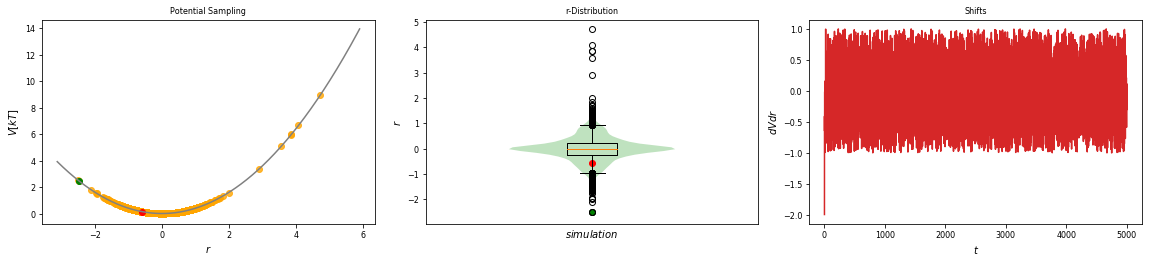

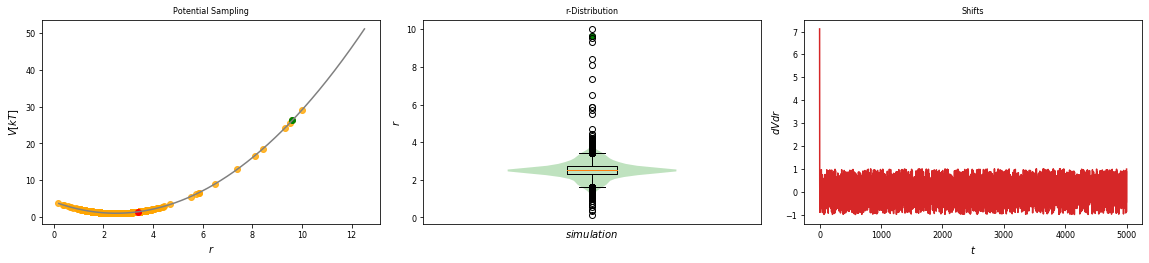

In [4]:
#Simulate the two states:
steps = simulation_steps_total_per_approach//2
equilibration_steps = 100

##Build Systems
integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
system1 = system(potential=h1, integrator=integrator)
system2 = system(potential=h2, integrator=integrator)

system1.simulate(steps, withdrawTraj=True, initSystem=True)
state1_traj = system1.getTrajectory()
static_sim_plots(system1)

system2.simulate(steps, withdrawTraj=True, initSystem=True)
state2_traj = system2.getTrajectory()
static_sim_plots(system2)
pass

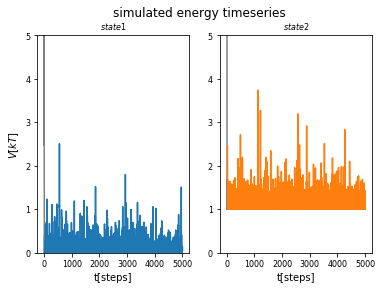

In [12]:
#Visualisation
fig, axes = plt.subplots(ncols=2)
axes[0].plot(list(state1_traj.index[:equilibration_steps]), state1_traj.totEnergy[:equilibration_steps], c="grey")
axes[0].plot(list(state1_traj.index[equilibration_steps:]), state1_traj.totEnergy[equilibration_steps:], c="C0")
axes[0].set_ylim([0,5])
axes[0].set_title("$state1$")
axes[0].set_xlabel("t[steps]")
axes[0].set_ylabel("$V[kT]$")

axes[1].plot(list(state2_traj.index[:equilibration_steps]), state2_traj.totEnergy[:equilibration_steps], c="grey")
axes[1].plot(list(state2_traj.index[equilibration_steps:]), state2_traj.totEnergy[equilibration_steps:], c="C1")
axes[1].set_ylim([0,5])
axes[1].set_title("$state2$")
axes[1].set_xlabel("t[steps]")
fig.suptitle("simulated energy timeseries")

pass

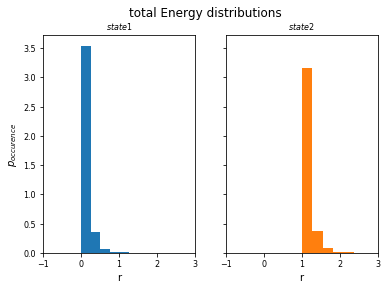

In [13]:
#Visualisation
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
axes[0].hist(state1_traj.totEnergy[equilibration_steps:], color="C0", density=True)
axes[0].set_title("$state1$")
axes[0].set_xlim([-1,3])
axes[0].set_xlabel("r")
axes[0].set_ylabel("$p_{occurence}$")

axes[1].hist(state2_traj.totEnergy[equilibration_steps:], color="C1", density=True)
axes[1].set_title("$state2$")
axes[1].set_xlim([-1,3])
axes[1].set_xlabel("r")

fig.suptitle("total Energy distributions")

pass

### Analysis
#### Zwanzig Equation

In [14]:
V1=state1_traj.totEnergy[equilibration_steps:]
V2=state2_traj.totEnergy[equilibration_steps:]

zwanz = zwanzigEquation(kT=True)
dF_zwanzig = zwanz.calculate(Vi=V1, Vj=V2)

print("Expected Result: ", dG_expected)
print("Zwanzig Result: ", dF_zwanzig)
print()
print("Difference:", dF_zwanzig - dG_expected)


Expected Result:  1.111571775657105
Zwanzig Result:  0.988511265210585

Difference: -0.12306051044652011


#### Bennet Acceptance Ratio (BAR)

In [15]:
#Sampling l1
V11=h1.ene(state1_traj.position)
V21=h2.ene(state1_traj.position)

#Sampling l2
V12=h1.ene(state2_traj.position)
V22=h2.ene(state2_traj.position)

bar = bennetAcceptanceRatio(kT=True)
dF_bar = bar.calculate(Vj_i=V21, Vi_i=V11, Vi_j=V12, Vj_j=V22)

print()
print("Expected Result: ", dG_expected)
print("BAR Result: ", dF_bar)
print()
print("Difference:", dF_bar - dG_expected)


Iteration: 0	dF: 1.512398683019691638251146330		tDiff:  1.512398683019691638251146330 convRad 1e-05 	newC 1.512398683019691638251146330 

Iteration: 1	dF: 1.197116719815770746360871518		tDiff:  0.315281963203920891890274812 convRad 1e-05 	newC 1.197116719815770746360871518 

Iteration: 2	dF: 1.244599578211040760356941157		tDiff:  0.047482858395270013996069639 convRad 1e-05 	newC 1.244599578211040760356941157 

Iteration: 3	dF: 1.236920588587480885309383837		tDiff:  0.007678989623559875047557320 convRad 1e-05 	newC 1.236920588587480885309383837 

Iteration: 4	dF: 1.238149273256012188104318353		tDiff:  0.001228684668531302794934516 convRad 1e-05 	newC 1.238149273256012188104318353 

Iteration: 5	dF: 1.237952336627449295295761149		tDiff:  0.000196936628562892808557204 convRad 1e-05 	newC 1.237952336627449295295761149 

Iteration: 6	dF: 1.237983893403055506135690995		tDiff:  0.000031556775606210839929846 convRad 1e-05 	newC 1.237983893403055506135690995 

Iteration: 7	dF: 1.237978836577538

# Linear Coupling Method - Thermodynamic Integration (TI)

## Sampling

Text(0.5, 1.0, 'Sampled Potentials')

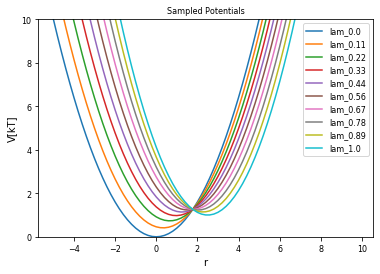

In [9]:
#Build Potential
V_perturbed = pot.linearCoupledPotentials(Va=h1, Vb=h2)

#Visualize
lambda_points = 10
positions = np.arange(-5,10, 0.2)
lambda_windows=np.linspace(0,1, lambda_points)
for lam in lambda_windows:
    V_perturbed.set_lam(lam)
    ene =  V_perturbed.ene(positions)
    plt.plot(positions,ene, label="lam_"+str(round(lam, 2)))
    
plt.legend()
plt.ylim([0,10])
plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")

In [14]:
steps = simulation_steps_total_per_approach//lambda_points
equilibration_steps = 30

integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
system = perturbedSystem(potential=V_perturbed, integrator=integrator)

system_trajs = {}
for lam in lambda_windows:
    system.set_lam(lam)
    system.simulate(steps, withdrawTraj=True, initSystem=True)
    system_trajs.update({lam: system.trajectory})


### Analysis

In [15]:
system_trajs[lam].head()
 

position  temperature  totEnergy  totPotEnergy  totKinEnergy  \
0   2.197023951692939        298.0   1.144216      1.144216           NaN   
1  -9.271273647628952        298.0  70.281442     70.281442           NaN   
2  -8.916153422558551        298.0  66.164279     66.164279           NaN   
3  -8.030758425800492        298.0  56.448437     56.448437           NaN   
4  -7.431012225914594        298.0  50.312502     50.312502           NaN   

                 dhdpos  velocity       lam     dhdlam  
0  -0.16880466407450234       NaN  0.888889  -0.884868  
1   0.34495344320426835       NaN  1.000000  35.898836  
2   0.35512022507040075       NaN  1.000000  34.365163  
3    0.8853949967580595       NaN  1.000000  30.651204  
4    0.5997461998858983       NaN  1.000000  28.224525

Text(0.5, 0.98, 'Lambda points')

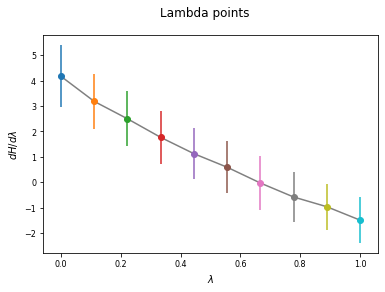

In [16]:
fig, axes = plt.subplots(ncols=1)

lam_stats = {}
for lam in system_trajs:
    lam_mean, lam_std = np.mean(system_trajs[lam].dhdlam[equilibration_steps:]), np.std(system_trajs[lam].dhdlam[equilibration_steps:])
    lam_stats.update({lam:{"mean":lam_mean, "std": lam_std}})
    
    axes.scatter(lam, lam_mean)
    axes.errorbar(lam, lam_mean, lam_std)

axes.plot(sorted(lam_stats), [lam_stats[x]["mean"] for x in sorted(lam_stats)], color="grey", zorder=-1)
axes.set_ylabel("$dH/d\lambda$")
axes.set_xlabel("$\lambda$")

fig.suptitle("Lambda points")


In [17]:
from scipy import integrate

lam = list(sorted(lam_stats.keys()))
means = [lam_stats[x]['mean'] for x in lam] 
stds = [lam_stats[x]['std'] for x in lam] 


In [18]:
dF_trapez = integrate.trapz(x=lam, y=means)
dF_err = integrate.trapz(x=lam, y=stds)

print()
print("Expected Result: ", dG_expected)
print("trapez Rule Result: ", dF_trapez, "+-", dF_err)
print()
print("Difference:", dF_trapez - dG_expected)



Expected Result:  1.111571775657105
trapez Rule Result:  0.9914972930758774 +- 1.0260105280743328

Difference: -0.12007448258122766


In [19]:
# or kepschler Weinfass method @gerhard
dF_simpson = integrate.simps(x=lam, y=means)
dF_err = integrate.simps(x=lam, y=stds)

print()
print("Expected Result: ", dG_expected)
print("trapez Rule Result: ", dF_simpson, "+-", dF_err)
print()
print("Difference:", dF_simpson - dG_expected)


Expected Result:  1.111571775657105
trapez Rule Result:  0.9872578439207831 +- 1.0247953273543347

Difference: -0.12431393173632199


## Exponentially Coupled - Enveloping Distribution Sampling (EDS) - BAR/RewightedFEP

In [21]:
#Build Potential
Eoff = [0,0]
s=1
V_eds = pot.envelopedPotential(V_is=[h1, h2], s=s, Eoff_i=Eoff)

s1 = 1.0
s2 = 0.5
s3 = 0.1

#Visualize
positions = np.arange(-5,10, 0.2)

plt.plot(positions,h1.ene(positions), label="state1", lw=2, color="grey")
plt.plot(positions,h2.ene(positions), label="state2", lw=2, color="black")
V_eds.s=s1
plt.plot(positions,V_eds.ene(positions), label="$V_r="+str(s1)+"$")
V_eds.s=s2
plt.plot(positions,V_eds.ene(positions), label="$V_r="+str(s2)+"$")
V_eds.s=s3
plt.plot(positions,V_eds.ene(positions), label="$V_r="+str(s3)+"$")


plt.legend()  
plt.ylim([-2,10])
plt.xlim([-2,8])

plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")

TypeError: 'NoneType' object cannot be interpreted as an integer

In [17]:
steps = simulation_steps_total_per_approach
equilibration_steps = 100

integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
system = edsSystem(potential=V_eds, integrator=integrator)

system.set_s(s1)
system.simulate(steps, withdrawTraj=True, initSystem=True)
state1_traj = system.getTrajectory()

system.set_s(s2)
system.simulate(steps, withdrawTraj=True, initSystem=True)
state2_traj = system.getTrajectory()

system.set_s(s3)
system.simulate(steps, withdrawTraj=True, initSystem=True)
state3_traj = system.getTrajectory()


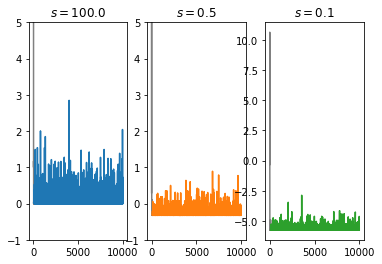

In [18]:
#Visualisation
fig, axes = plt.subplots(ncols=3)
axes[0].plot(list(state1_traj.index[:equilibration_steps]), state1_traj.totEnergy[:equilibration_steps], c="grey")
axes[0].plot(list(state1_traj.index[equilibration_steps:]), state1_traj.totEnergy[equilibration_steps:], c="C0")
axes[0].set_ylim([-1,5])
axes[0].set_title("$s = "+str(state1_traj.s[1])+"$")

axes[1].plot(list(state2_traj.index[:equilibration_steps]), state2_traj.totEnergy[:equilibration_steps], c="grey")
axes[1].plot(list(state2_traj.index[equilibration_steps:]), state2_traj.totEnergy[equilibration_steps:], c="C1")
axes[1].set_ylim([-1,5])
axes[1].set_title("$s =  "+str(state2_traj.s[1])+"$")

axes[2].plot(list(state3_traj.index[:equilibration_steps]), state3_traj.totEnergy[:equilibration_steps], c="grey")
axes[2].plot(list(state3_traj.index[equilibration_steps:]), state3_traj.totEnergy[equilibration_steps:], c="C2")
#axes[2].set_ylim([-1,5])
axes[2].set_title("$s =  "+str(state3_traj.s[1])+"$")
pass

### FEP-EDS_Evaluation

In [19]:
print("SIMULATION 1")
print("\ts = ", s1)
positions = state1_traj.position[equilibration_steps:]
Vr = state1_traj.totEnergy[equilibration_steps:]
V1 = h1.ene(positions)
V2 = h2.ene(positions)


rew_zwanz = threeStateZwanzigReweighting(kT=True)
dFRew_zwanz = rew_zwanz.calculate(Vi=V2, Vj=V1, Vr=Vr)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dFRew_zwanz)
print()
print("\tDifference:", dFRew_zwanz - dG_expected)
print("\n\n\n")

print("SIMULATION 2")
print("\ts = ", s2)
positions = state2_traj.position[equilibration_steps:]
Vr = state2_traj.totEnergy[equilibration_steps:]
V1 = h1.ene(positions)
V2 = h2.ene(positions)


rew_zwanz = threeStateZwanzigReweighting(kT=True)
dFRew_zwanz = rew_zwanz.calculate(Vi=V2, Vj=V1, Vr=Vr)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dFRew_zwanz)
print()
print("\tDifference:", dFRew_zwanz - dG_expected)
print("\n\n\n")

print("SIMULATION 3")
print("\ts = ", s3)
positions = state3_traj.position[equilibration_steps:]
Vr = state3_traj.totEnergy[equilibration_steps:]
V1 = h1.ene(positions)
V2 = h2.ene(positions)


rew_zwanz = threeStateZwanzigReweighting(kT=True)
dFRew_zwanz = rew_zwanz.calculate(Vi=V2, Vj=V1, Vr=Vr)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dFRew_zwanz)
print()
print("\tDifference:", dFRew_zwanz - dG_expected)
print("\n\n\n")


SIMULATION 1
	s =  100.0

	Expected Result:  1.111571775657105
	dF_Calc Result:  5.181259104060588

	Difference: 4.069687328403483




SIMULATION 2
	s =  0.5

	Expected Result:  1.111571775657105
	dF_Calc Result:  3.04218028951811

	Difference: 1.930608513861005




SIMULATION 3
	s =  0.1

	Expected Result:  1.111571775657105
	dF_Calc Result:  1.030310386784433

	Difference: -0.08126138887267209






### BAR-EDS_Evaluation

In [20]:
print("SIMULATION 3")
print("\ts = ", s3)
positions = state3_traj.position[equilibration_steps:]
Vr = state3_traj.totEnergy[equilibration_steps:]
V1 = h1.ene(positions)
V2 = h2.ene(positions)

#define states
V12 = [V1_x for V1_x, V2_x in zip(V1, V2) if (V1_x > V2_x)]
V22 = [V2_x for V1_x, V2_x in zip(V1, V2) if (V1_x > V2_x)]
V21 = [V2_x for V1_x, V2_x in zip(V1, V2) if (V1_x < V2_x)]
V11 = [V1_x for V1_x, V2_x in zip(V1, V2) if (V1_x < V2_x)]


#bar
bar = bennetAcceptanceRatio(kT=True)
dF_bar = bar.calculate(Vj_i=V21, Vi_i=V11, Vi_j=V12, Vj_j=V22)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dF_bar)
print()
print("\tDifference:", dF_bar - dG_expected)
print("\n\n\n")



SIMULATION 3
	s =  0.1
Iteration: 0	dF: 0.7474849262351751643530353330		tDiff:  0.7474849262351751643530353330 convRad 1e-05 	newC 0.7474849262351751643530353330 

Iteration: 1	dF: 0.6512818610796029005678957920		tDiff:  0.0962030651555722637851395410 convRad 1e-05 	newC 0.6512818610796029005678957920 

Iteration: 2	dF: 0.6614318360842033025267078580		tDiff:  0.0101499750046004019588120660 convRad 1e-05 	newC 0.6614318360842033025267078580 

Iteration: 3	dF: 0.6603309456879891724658779450		tDiff:  0.0011008903962141300608299130 convRad 1e-05 	newC 0.6603309456879891724658779450 

Iteration: 4	dF: 0.6604500060060337427146634070		tDiff:  0.0001190603180445702487854620 convRad 1e-05 	newC 0.6604500060060337427146634070 

Iteration: 5	dF: 0.6604371256947337319341594170		tDiff:  0.0000128803113000107805039900 convRad 1e-05 	newC 0.6604371256947337319341594170 

Iteration: 6	dF: 0.6604385190791022528671337110		tDiff:  0.0000013933843685209329742940 convRad 1e-05 	newC 0.660438519079102252867

In [21]:
print("SIMULATION 1")
print("\ts = ", s3)
positions = state1_traj.position[equilibration_steps:]
Vr = state1_traj.totEnergy[equilibration_steps:]
V1 = h1.ene(positions)
V2 = h2.ene(positions)

#define states
V12 = [V1_x for V1_x, V2_x in zip(V1, V2) if (V1_x > V2_x)]
V22 = [V2_x for V1_x, V2_x in zip(V1, V2) if (V1_x > V2_x)]
V21 = [V2_x for V1_x, V2_x in zip(V1, V2) if (V1_x < V2_x)]
V11 = [V1_x for V1_x, V2_x in zip(V1, V2) if (V1_x < V2_x)]

print(len(V12), len(V11))

#bar
bar = bennetAcceptanceRatio(kT=True)
dF_bar = bar.calculate(Vj_i=V21, Vi_i=V11, Vi_j=V12, Vj_j=V22)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dF_bar)
print()
print("\tDifference:", dF_bar - dG_expected)
print("\n\n\n")



SIMULATION 1
	s =  0.1
53 9848
Iteration: 0	dF: 1.594403218437532082107849918		tDiff:  1.594403218437532082107849918 convRad 1e-05 	newC 1.594403218437532082107849918 

Iteration: 1	dF: 1.346238255014802253230805938		tDiff:  0.248164963422729828877043980 convRad 1e-05 	newC 1.346238255014802253230805938 

Iteration: 2	dF: 1.367972828610554749518578208		tDiff:  0.021734573595752496287772270 convRad 1e-05 	newC 1.367972828610554749518578208 

Iteration: 3	dF: 1.365881974667452067641490345		tDiff:  0.002090853943102681877087863 convRad 1e-05 	newC 1.365881974667452067641490345 

Iteration: 4	dF: 1.366081467382205990004924985		tDiff:  0.000199492714753922363434640 convRad 1e-05 	newC 1.366081467382205990004924985 

Iteration: 5	dF: 1.366062418311939573040899987		tDiff:  0.000019049070266416964024998 convRad 1e-05 	newC 1.366062418311939573040899987 

Iteration: 6	dF: 1.366064237123739529541724486		tDiff:  0.000001818811799956500824499 convRad 1e-05 	newC 1.366064237123739529541724486 

Fin

In [22]:
print("SIMULATION 2")
print("\ts = ", s2)
positions = state2_traj.position[equilibration_steps:]
Vr = state2_traj.totEnergy[equilibration_steps:]
V1 = h1.ene(positions)
V2 = h2.ene(positions)

#define states
V12 = [V1_x for V1_x, V2_x in zip(V1, V2) if (V1_x > V2_x)]
V22 = [V2_x for V1_x, V2_x in zip(V1, V2) if (V1_x > V2_x)]
V21 = [V2_x for V1_x, V2_x in zip(V1, V2) if (V1_x < V2_x)]
V11 = [V1_x for V1_x, V2_x in zip(V1, V2) if (V1_x < V2_x)]

print(len(V12), len(V11))

#bar
bar = bennetAcceptanceRatio(kT=True)
dF_bar = bar.calculate(Vj_i=V21, Vi_i=V11, Vi_j=V12, Vj_j=V22)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dF_bar)
print()
print("\tDifference:", dF_bar - dG_expected)
print("\n\n\n")



SIMULATION 2
	s =  0.5
141 9760
Iteration: 0	dF: 0.9131882102036073407137828007		tDiff:  0.9131882102036073407137828007 convRad 1e-05 	newC 0.9131882102036073407137828007 

Iteration: 1	dF: 0.7005198959286793233234430793		tDiff:  0.2126683142749280173903397214 convRad 1e-05 	newC 0.7005198959286793233234430793 

Iteration: 2	dF: 0.7394648913982391763327296217		tDiff:  0.0389449954695598530092865424 convRad 1e-05 	newC 0.7394648913982391763327296217 

Iteration: 3	dF: 0.7318886358480196963439864233		tDiff:  0.0075762555502194799887431984 convRad 1e-05 	newC 0.7318886358480196963439864233 

Iteration: 4	dF: 0.7333465089274511213225106057		tDiff:  0.0014578730794314249785241824 convRad 1e-05 	newC 0.7333465089274511213225106057 

Iteration: 5	dF: 0.7330653776722915229191242563		tDiff:  0.0002811312551595984033863494 convRad 1e-05 	newC 0.7330653776722915229191242563 

Iteration: 6	dF: 0.7331195678757356748579321177		tDiff:  0.0000541902034441519388078614 convRad 1e-05 	newC 0.733119567875

In [23]:
print("SIMULATION 1")
print("\ts = ", s1)
positions = state1_traj.position[equilibration_steps:]
Vr = state1_traj.totEnergy[equilibration_steps:]
V1 = h1.ene(positions)
V2 = h2.ene(positions)

#define states
V12 = V1
V22 = Vr
V21 = V2
V11 = Vr

print(len(V12), len(V11))

#bar
bar = bennetAcceptanceRatio(kT=True)
dF_bar = bar.calculate(Vj_i=V21, Vi_i=V11, Vi_j=V12, Vj_j=V22)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dF_bar)
print()
print("\tDifference:", dF_bar - dG_expected)
print("\n\n\n")



SIMULATION 1
	s =  100.0
9901 9901
Iteration: 0	dF: 0.6666135563382276152055468815		tDiff:  0.6666135563382276152055468815 convRad 1e-05 	newC 0.6666135563382276152055468815 

Iteration: 1	dF: 0.4016572917904901021030558055		tDiff:  0.2649562645477375131024910760 convRad 1e-05 	newC 0.4016572917904901021030558055 

Iteration: 2	dF: 0.4950508731846490364384554240		tDiff:  0.0933935813941589343353996185 convRad 1e-05 	newC 0.4950508731846490364384554240 

Iteration: 3	dF: 0.4603799747668247632550380164		tDiff:  0.0346708984178242731834174076 convRad 1e-05 	newC 0.4603799747668247632550380164 

Iteration: 4	dF: 0.4730253044085339517362527906		tDiff:  0.0126453296417091884812147742 convRad 1e-05 	newC 0.4730253044085339517362527906 

Iteration: 5	dF: 0.4683825017647737186307334485		tDiff:  0.0046428026437602331055193421 convRad 1e-05 	newC 0.4683825017647737186307334485 

Iteration: 6	dF: 0.4700830247178629790730896428		tDiff:  0.0017005229530892604423561943 convRad 1e-05 	newC 0.470083024

# Hybrid Methods - $\lambda-EDS $

In [ ]:
# 

# Enhanced Sampling with system Coupling

# RE-EDS

In [37]:
#potential
Eoff = [0,0.65]
s=1
V_eds = pot.envelopedPotential(V_is=[h1, h2], s=s, Eoff_i=Eoff)

##Integrator
integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)

##System
eds_system = edsSystem(integrator=integrator, potential=V_eds)


##Ensemble
from ensembler.ensemble import replica_exchange
##Ensemble Settings:
s_values = np.logspace(start=0, stop=-1, num=3)
s_values = [100, 0.3, 0.1]
trials=20
steps_between_trials=simulation_steps_total_per_approach//(3*trials)

ensemble = replica_exchange.ReplicaExchangeEnvelopingDistributionSampling(system=eds_system, exchange_criterium=None, s_range=s_values, steps_between_trials=steps_between_trials)


In [38]:
ensemble.simulate(trials, reset_ensemble=True)


original Coords  [0, 1, 2]
swapped Coords  [1, 0, 2]
origTotE  [0.0013337418696650722, -1.3209470440886792, -5.744081891744135]
SWPTotE  [-1.3209470440886792, 0.0013337418696650722, -5.744081891744135]
Exchange:  {(0, 1): True}
exchaning param:  _currentPosition


original Coords  [0, 1, 2]
swapped Coords  [0, 2, 1]
origTotE  [0.23989754818633008, -1.428638849103526, -6.062348351223567]
SWPTotE  [0.23989754818633008, -6.062348351223567, -1.428638849103526]
Exchange:  {(1, 2): True}
exchaning param:  _currentPosition


original Coords  [0, 1, 2]
swapped Coords  [1, 0, 2]
origTotE  [0.25154618375613763, -1.443231734511644, -5.829113365166824]
SWPTotE  [-1.443231734511644, 0.25154618375613763, -5.829113365166824]
Exchange:  {(0, 1): True}
exchaning param:  _currentPosition


original Coords  [0, 1, 2]
swapped Coords  [0, 2, 1]
origTotE  [0.00010546966905970774, -1.430868559486592, -6.062491516666322]
SWPTotE  [0.00010546966905970774, -6.062491516666322, -1.430868559486592]
Exchange:  {(1, 2): True}
exchaning param:  _currentPosition


original Coords  [0, 1, 2]
swapped Coords  [1, 0, 2]
origTotE  [0.1339803354642591, -1.4413941640399948, -6.05337516154454]
SWPTotE  [-1.4413941640399948, 0.1339803354642591, -6.05337516154454]
Exchange:  {(0, 1): True}
exchaning param:  _currentPosition


original Coords  [0, 1, 2]
swapped Coords  [0, 2, 1]
origTotE  [0.033468148037254696, -1.43402735617349, -5.868379485343345]
SWPTotE  [0.033468148037254696, -5.868379485343345, -1.43402735617349]
Exchange:  {(1, 2): True}
exchaning param:  _currentPosition


original Coords  [0, 1, 2]
swapped Coords  [1, 0, 2]
origTotE  [0.007381827006690294, -1.3640096678149531, -6.0603678116414095]
SWPTotE  [-1.3640096678149531, 0.007381827006690294, -6.0603678116414095]
Exchange:  {(0, 1): True}
exchaning param:  _currentPosition


original Coords  [0, 1, 2]
swapped Coords  [0, 2, 1]
origTotE  [0.09899546625818503, -1.3713465575286008, -5.875802997868366]
SWPTotE  [0.09899546625818503, -5.875802997868366, -1.3713465575286008]
Exchange:  {(1, 2): True}
exchaning param:  _currentPosition


original Coords  [0, 1, 2]
swapped Coords  [1, 0, 2]
origTotE  [0.013416777515950285, -1.4432192697873052, -6.058996510889653]
SWPTotE  [-1.4432192697873052, 0.013416777515950285, -6.058996510889653]
Exchange:  {(0, 1): True}
exchaning param:  _currentPosition


original Coords  [0, 1, 2]
swapped Coords  [0, 2, 1]
origTotE  [0.10008323505233852, -1.2576979319951174, -6.016739977035383]
SWPTotE  [0.10008323505233852, -6.016739977035383, -1.2576979319951174]
Exchange:  {(1, 2): True}
exchaning param:  _currentPosition


original Coords  [0, 1, 2]
swapped Coords  [1, 0, 2]
origTotE  [0.0005278429287599178, -1.2339561666930845, -5.9638595635478575]
SWPTotE  [-1.2339561666930845, 0.0005278429287599178, -5.9638595635478575]
Exchange:  {(0, 1): True}
exchaning param:  _currentPosition


original Coords  [0, 1, 2]
swapped Coords  [0, 2, 1]
origTotE  [0.04841884401898233, -1.4429092646388728, -5.858815958277761]
SWPTotE  [0.04841884401898233, -5.858815958277761, -1.4429092646388728]
Exchange:  {(1, 2): True}
exchaning param:  _currentPosition


original Coords  [0, 1, 2]
swapped Coords  [1, 0, 2]
origTotE  [0.3827501938000185, -1.443492565915036, -5.83745945324726]
SWPTotE  [-1.443492565915036, 0.3827501938000185, -5.83745945324726]
Exchange:  {(0, 1): True}
exchaning param:  _currentPosition


original Coords  [0, 1, 2]
swapped Coords  [0, 2, 1]
origTotE  [0.002948128740784142, -1.44189163151166, -6.062519618296221]
SWPTotE  [0.002948128740784142, -6.062519618296221, -1.44189163151166]
Exchange:  {(1, 2): True}
exchaning param:  _currentPosition


original Coords  [0, 1, 2]
swapped Coords  [1, 0, 2]
origTotE  [0.0009489521138711939, -1.4084798120042634, -6.022926189440799]
SWPTotE  [-1.4084798120042634, 0.0009489521138711939, -6.022926189440799]
Exchange:  {(0, 1): True}
exchaning param:  _currentPosition


original Coords  [0, 1, 2]
swapped Coords  [0, 2, 1]
origTotE  [0.0011938012100735826, -1.4113504934026495, -6.01334577493335]
SWPTotE  [0.0011938012100735826, -6.01334577493335, -1.4113504934026495]
Exchange:  {(1, 2): True}
exchaning param:  _currentPosition


original Coords  [0, 1, 2]
swapped Coords  [1, 0, 2]
origTotE  [0.0014805239731453027, -1.232134438564014, -5.636207934106063]
SWPTotE  [-1.232134438564014, 0.0014805239731453027, -5.636207934106063]
Exchange:  {(0, 1): True}
exchaning param:  _currentPosition


original Coords  [0, 1, 2]
swapped Coords  [0, 2, 1]
origTotE  [7.642385840848352e-05, -1.258146820270571, -6.05879234452249]
SWPTotE  [7.642385840848352e-05, -6.05879234452249, -1.258146820270571]
Exchange:  {(1, 2): True}
exchaning param:  _currentPosition


original Coords  [0, 1, 2]
swapped Coords  [1, 0, 2]
origTotE  [0.48577673611098604, -1.4040842423874902, -5.822256599542514]
SWPTotE  [-1.4040842423874902, 0.48577673611098604, -5.822256599542514]
Exchange:  {(0, 1): True}
exchaning param:  _currentPosition


original Coords  [0, 1, 2]
swapped Coords  [0, 2, 1]
origTotE  [0.18504364834985113, -1.4398006298465997, -6.062287157218266]
SWPTotE  [0.18504364834985113, -6.062287157218266, -1.4398006298465997]
Exchange:  {(1, 2): True}
exchaning param:  _currentPosition



In [39]:
[replica.potential.s for repID, replica in ensemble.replicas.items()]

[100, 0.3, 0.1]

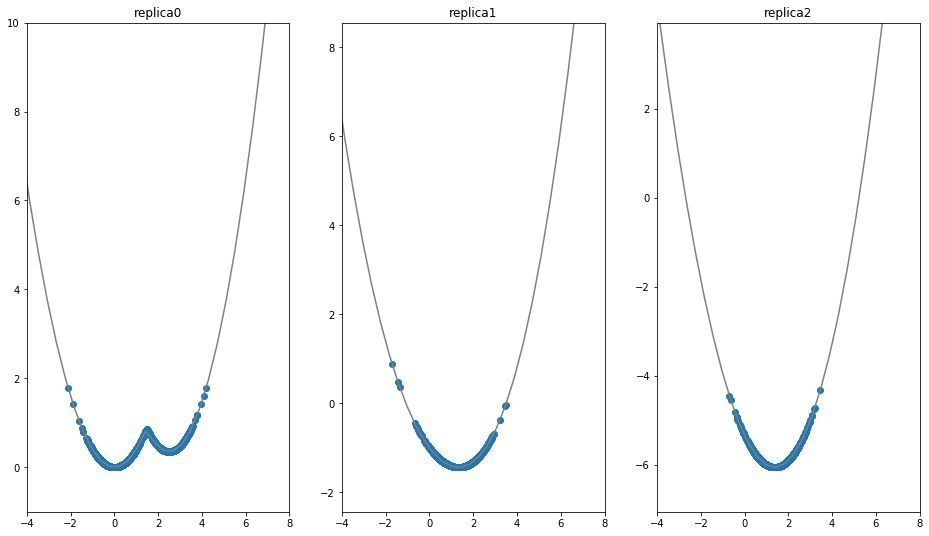

In [44]:
trajs = ensemble.get_trajectories()

positions = np.linspace(-10,10)
fig, axes = plt.subplots(ncols=len(trajs), figsize=[16,9])
eqil=100
for traj, ax in zip(trajs, axes):
    ax.plot(positions, ensemble.replicas[traj].potential.ene(positions), c="grey")
    min_e = np.min(trajs[traj].totEnergy[eqil:])

    ax.scatter(trajs[traj].position[eqil:], trajs[traj].totEnergy[eqil:])
    ax.set_ylim([min_e-1,min_e+10])
    ax.set_xlim([-4,8])
    ax.set_title("replica"+str(traj))


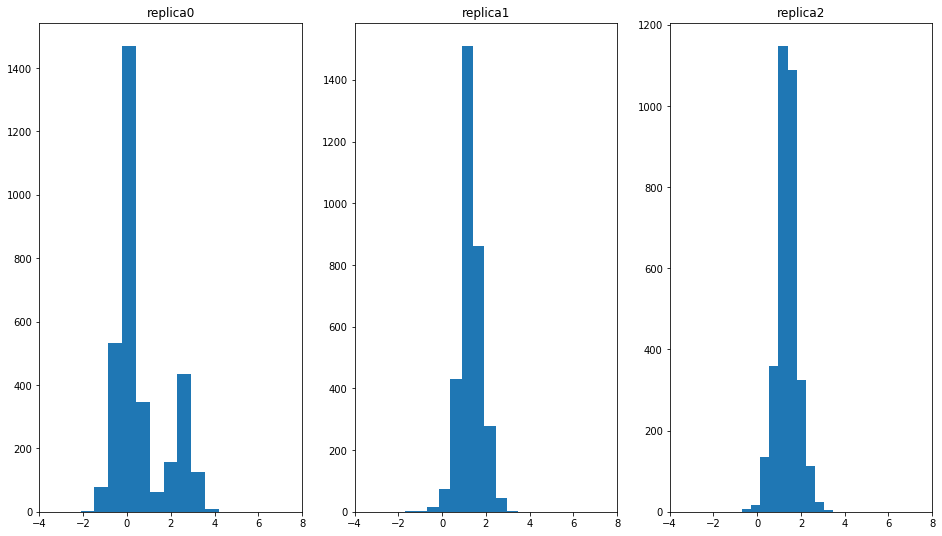

In [45]:
trajs = ensemble.get_trajectories()

positions = np.linspace(-10,10)
fig, axes = plt.subplots(ncols=len(trajs), figsize=[16,9])
eqil=100
for traj, ax in zip(trajs, axes):
    ax.hist(trajs[traj].position[eqil:])
    ax.set_xlim([-4,8])
    ax.set_title("replica"+str(traj))


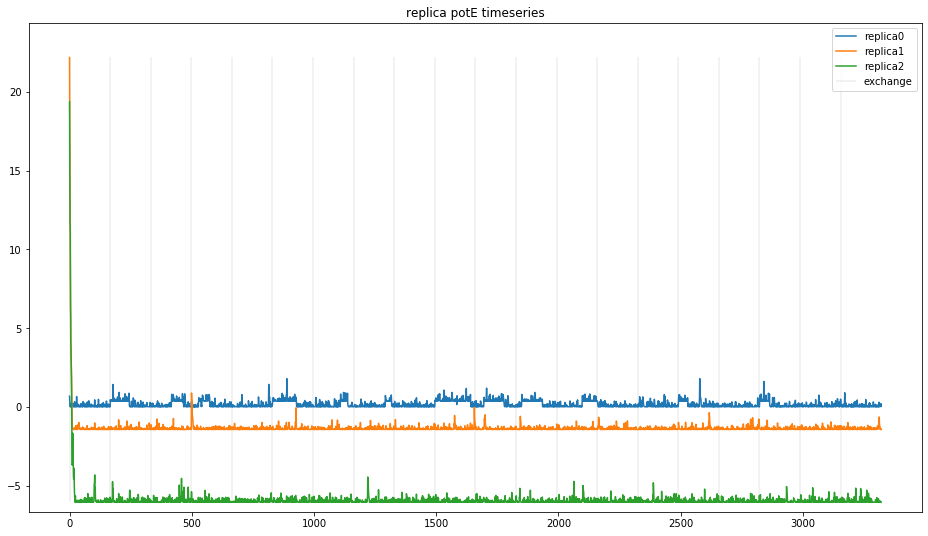

In [42]:

fig, ax = plt.subplots(ncols=1, figsize=[16,9])
enes = [trajs[x].totEnergy for x in sorted(trajs)] 
min_e = np.min(enes)
max_e = np.max(enes)

for ind, ene in enumerate(enes):
    ax.plot(ene, label="replica"+str(ind))
ax.vlines([steps_between_trials*x for x in range(trials)], ymin=min_e, ymax=max_e, label="exchange", lw=0.1)
ax.set_title("replica potE timeseries")
ax.set_ylim(1.1*min_e, 1.1*max_e)
ax.legend()

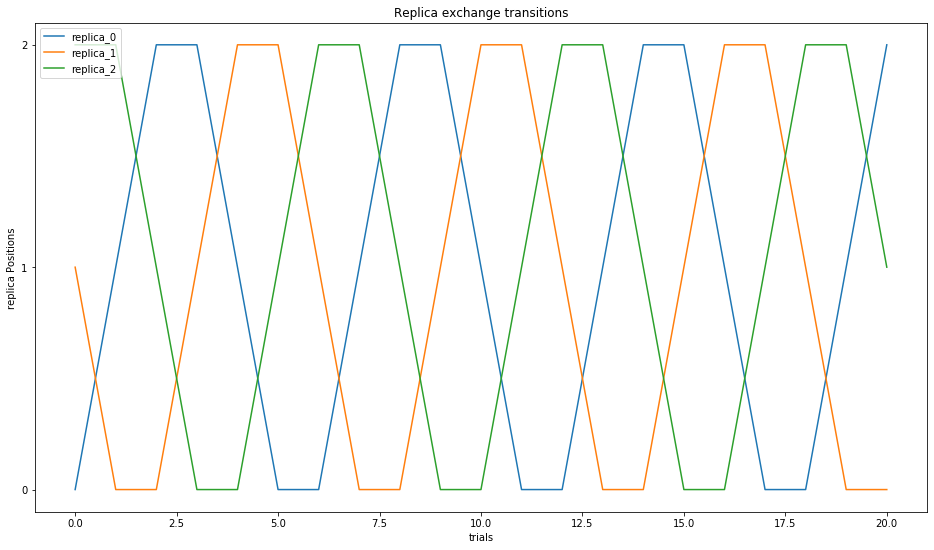

In [29]:
stats= ensemble.exchange_information
replicas = np.unique(ensemble.exchange_information.replicaID)
trials = np.unique(ensemble.exchange_information.nExchange)

import itertools as it

fig, ax = plt.subplots(ncols=1, figsize=[16,9])

replica_positions = {}
for replica in replicas:
    replica_positions.update({replica: stats.loc[stats.replicaID==replica].replicaPositionI})

    x = trials
    y = replica_positions[replica]

    ax.plot(x,y , label="replica_"+str(replica))

#plt.yticks(replicas+1, reversed(replicas+1))
ax.set_yticks(ticks=replicas)
ax.set_yticklabels(labels=replicas)

ax.set_ylabel("replica Positions")
ax.set_xlabel("trials")
ax.set_title("Replica exchange transitions")
if(len(replicas)<10): plt.legend()

In [47]:
#FREE E
equilibration_steps=100
print("Reeds Rep 0")
print("\ts = ", ensemble.exchange_dimensions['s'][0])
positions = trajs[0].position[equilibration_steps:]
Vr = trajs[0].totEnergy[equilibration_steps:]
V1 = h1.ene(positions)
V2 = h2.ene(positions)


rew_zwanz = threeStateZwanzigReweighting(kT=True)
dFRew_zwanz = rew_zwanz.calculate(Vi=V2, Vj=V1, Vr=Vr)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dFRew_zwanz)
print()
print("\tDifference:", dFRew_zwanz - dG_expected)
print("\n\n\n")

SIMULATION 3
	s =  100

	Expected Result:  1.111571775657105
	dF_Calc Result:  3.2368328158896937

	Difference: 2.125261040232589




